In [67]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated, Optional, List
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
from pydantic import BaseModel, Field
import operator
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

In [107]:
class CategorySelection(BaseModel):
    """Category selection by LLM"""
    issue_type: Literal[
        "Akaash MyCloud", "Asset Loss", "BaaS-Restore",
        "Client Connectivity-Application performance issue",
        "Cortex", "DBaas", "SAP Outage", "VPN Not Connecting",
        "Outlook/Email Issue", "Password Reset", "Printer Issue",
        "Network Outage", "HR Portal Access", "Security Alert",
        "Server Down", "Storage Issue", "Teams/Collab Issue",
        "Payroll Access Issue", "Laptop Performance", "Access Request"
    ]
    confidence: Literal["high", "medium", "low"]
    alternative_categories: List[str] = Field(default=[])
    reasoning: str = Field(description="Why this category was selected")


class RiskAssessment(BaseModel):
    """Risk level assessment"""
    risk_level: Literal["Low", "Medium", "High"]
    reasoning: str
    requires_immediate_attention: bool


# ============= STATE DEFINITION =============

class TicketState(TypedDict):
    """Complete state for ticket workflow"""
    # User Info (pre-populated)
    user_name: str
    emp_id: str
    entity: Literal["Infosys Limited", "Infosys BPM", "McCamish", "EdgeVerve"]
    location: Literal["BLR_EGL", "BLR_ECITY", "PUN_HINJ", "HYD_SEZ", "CHN_MCITY", "MYS_GEC", "TVM_TECH"]
    
    # Query Info
    user_query: str
    
    # Processed Info
    category: Optional[str]
    department: Optional[str]
    confidence: Optional[str]
    alternative_categories: List[str]
    category_reasoning: Optional[str]
    
    # Risk Assessment
    risk_level: Optional[str]
    risk_reasoning: Optional[str]
    requires_immediate_attention: bool
    
    # Ticket Info
    ticket_no: Optional[str]
    ticket_status: Optional[str]
    assigned_to: Optional[str]
    isTicketCreated: bool
    
    # Workflow control
    needs_user_selection: bool
    available_options: List[dict]
    
    # Messages/logs
    messages: Annotated[List[str], operator.add]


DEPT_MAP = {
    "Akaash MyCloud": "CCD", "Asset Loss": "ISG", "BaaS-Restore": "CCD",
    "Client Connectivity-Application performance issue": "CCD",
    "Cortex": "ISG", "DBaas": "CCD", "SAP Outage": "SAP",
    "VPN Not Connecting": "NET", "Outlook/Email Issue": "MSG",
    "Password Reset": "IDM", "Printer Issue": "ITOPS",
    "Network Outage": "NET", "HR Portal Access": "HR",
    "Security Alert": "SEC", "Server Down": "ITOPS",
    "Storage Issue": "STO", "Teams/Collab Issue": "MSG",
    "Payroll Access Issue": "HR", "Laptop Performance": "ITOPS",
    "Access Request": "IDM"
}

In [108]:
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [109]:
CATEGORY_CONTEXT = """
## Category Matching Guidelines:

**Akaash MyCloud**: VM issues, cloud infrastructure, MyCloud platform problems
**Asset Loss**: Lost/stolen devices, laptops, phones, security breach of physical assets
**BaaS-Restore**: Backup restoration, file recovery, VM restore, NetBackup/Commvault issues
**Client Connectivity-Application performance issue**: Slow apps, latency, network slowness, packet loss
**Cortex**: Security alerts from Cortex XDR, endpoint detection, threat alerts
**DBaas**: Database service issues, DB instance problems, SQL errors, database crashes
**SAP Outage**: SAP system down, payroll stuck, SAP login issues
**VPN Not Connecting**: VPN connection failures, GlobalProtect, AnyConnect issues
**Outlook/Email Issue**: Email sync problems, Outlook errors, mailbox issues, Exchange problems
**Password Reset**: Forgotten passwords, locked accounts, login failures
**Printer Issue**: Printer not working, printing stuck, driver problems
**Network Outage**: Network down, no internet, WiFi issues, switch/router failures
**HR Portal Access**: HR system access issues, leave portal, timesheet problems
**Security Alert**: Malware, virus, phishing, ransomware, security breaches
**Server Down**: Application servers down, service unavailable, server crashes
**Storage Issue**: Low disk space, NAS/SAN issues, disk failures
**Teams/Collab Issue**: Microsoft Teams problems, meeting issues, chat sync problems
**Payroll Access Issue**: Payroll portal access, salary slip issues
**Laptop Performance**: Slow system, freezing, OS lagging, blue screen
**Access Request**: Need access to folders, drives, applications, permission issues
"""

In [110]:
class CategoryAgent:
    """Agent to categorize user query"""
    
    def __init__(self, llm: ChatGroq):
        self.llm = llm.with_structured_output(CategorySelection)
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", f"""You are an IT support categorization specialist.
            Analyze the user query and select the most appropriate category.
            
            {CATEGORY_CONTEXT}
            
            Be decisive but honest about confidence. If not sure, provide alternatives.
            """),
            ("human", "User: {name} (ID: {emp_id}) from {entity}\nQuery: {query}")
        ])
        self.chain = self.prompt | self.llm
    
    def __call__(self, state: TicketState) -> TicketState:
        """Categorize the query"""
        state["messages"].append(f"🤖 Category Agent: Analyzing query...")
        
        result = self.chain.invoke({
            "name": state["user_name"],
            "emp_id": state["emp_id"],
            "entity": state["entity"],
            "query": state["user_query"]
        })
        
        state["confidence"] = result.confidence
        state["category_reasoning"] = result.reasoning
        state["alternative_categories"] = result.alternative_categories
        
        # High confidence - auto select
        if result.confidence == "high":
            state["category"] = result.issue_type
            state["department"] = DEPT_MAP[result.issue_type]
            state["needs_user_selection"] = False
            state["messages"].append(
                f"✅ Category matched: {result.issue_type} (Confidence: HIGH)"
            )
        else:
            # Need user selection
            state["needs_user_selection"] = True
            options = [{"option": 1, "category": result.issue_type, "department": DEPT_MAP[result.issue_type]}]
            
            for idx, alt in enumerate(result.alternative_categories[:3], 2):
                if alt in DEPT_MAP:
                    options.append({"option": idx, "category": alt, "department": DEPT_MAP[alt]})
            
            state["available_options"] = options
            state["messages"].append(
                f"🤔 Multiple possible categories (Confidence: {result.confidence.upper()})"
            )
        
        return state


class RiskAssessmentAgent:
    """Agent to assess risk level"""
    
    def __init__(self, llm: ChatGroq):
        self.llm = llm.with_structured_output(RiskAssessment)
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a risk assessment specialist for IT incidents.
            
            Assess risk based on:
            - **HIGH**: Security breaches, critical system outages (SAP, DB, Server), network down
            - **MEDIUM**: VPN issues, email problems, application performance, backup restore
            - **LOW**: Password resets, printer issues, access requests, laptop performance
            
            Consider business impact and urgency.
            """),
            ("human", "Category: {category}\nQuery: {query}\nDepartment: {department}")
        ])
        self.chain = self.prompt | self.llm
    
    def __call__(self, state: TicketState) -> TicketState:
        """Assess risk level"""
        if not state["category"]:
            return state
        
        state["messages"].append(f"⚠️  Risk Assessment Agent: Evaluating severity...")
        
        result = self.chain.invoke({
            "category": state["category"],
            "query": state["user_query"],
            "department": state["department"]
        })
        
        state["risk_level"] = result.risk_level
        state["risk_reasoning"] = result.reasoning
        state["requires_immediate_attention"] = result.requires_immediate_attention
        
        state["messages"].append(
            f"📊 Risk Level: {result.risk_level} | Immediate attention: {result.requires_immediate_attention}"
        )
        
        return state


class TicketCreationAgent:
    """Agent to create ticket"""
    
    def __call__(self, state: TicketState) -> TicketState:
        """Create ticket with all details"""
        state["messages"].append(f"🎫 Ticket Creation Agent: Generating ticket...")
        
        # Generate ticket number
        from datetime import datetime
        import uuid
        state["ticket_no"] = f"INC{datetime.now().strftime('%Y%m%d')}{uuid.uuid4().hex[:6].upper()}"
        
        # Assign based on risk and department
        if state["risk_level"] == "High":
            state["assigned_to"] = f"L2-{state['department']}-Supervisor"
            state["ticket_status"] = "Escalated to L2"
        elif state["risk_level"] == "Medium":
            state["assigned_to"] = f"{state['department']}-MediumRisk-Agent"
            state["ticket_status"] = "Assigned to Agent"
        else:
            state["assigned_to"] = f"{state['department']}-Support"
            state["ticket_status"] = "In Queue"
        
        # Mark ticket as created
        state["isTicketCreated"] = True
        
        state["messages"].append(
            f"✅ Ticket created: {state['ticket_no']} | Assigned to: {state['assigned_to']}"
        )
        
        return state


In [111]:
def check_category_selection(state: TicketState) -> str:
    """Route based on category selection"""
    if state["needs_user_selection"]:
        return "wait_user_selection"
    else:
        return "assess_risk"


def route_by_risk(state: TicketState) -> str:
    """Route based on risk level"""
    risk = state["risk_level"]
    
    if risk == "High":
        return "create_high_risk_ticket"
    elif risk == "Medium":
        return "create_medium_risk_ticket"
    else:
        return "create_low_risk_ticket"

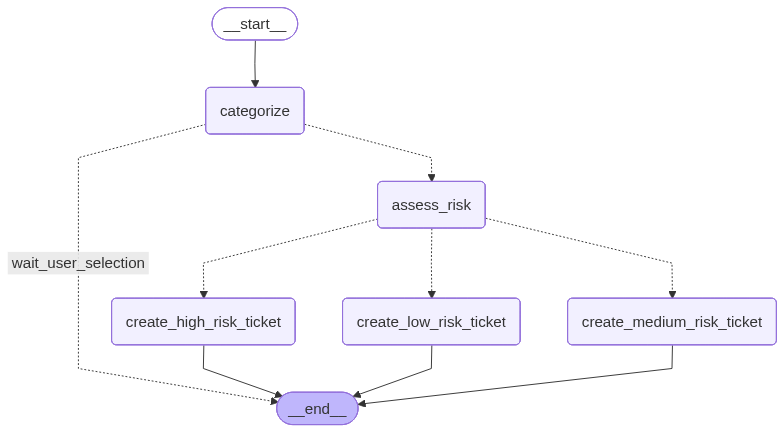

In [112]:

def build_workflow() -> StateGraph:
    """Build the complete workflow"""
    llm = ChatGroq(model="deepseek-r1-distill-llama-70b")
    
    # Initialize agents
    category_agent = CategoryAgent(llm)
    risk_agent = RiskAssessmentAgent(llm)
    ticket_agent = TicketCreationAgent()
    
    # Create workflow
    workflow = StateGraph(TicketState)
    
    # Add nodes
    workflow.add_node("categorize", category_agent)
    workflow.add_node("assess_risk", risk_agent)
    workflow.add_node("create_high_risk_ticket", ticket_agent)
    workflow.add_node("create_medium_risk_ticket", ticket_agent)
    workflow.add_node("create_low_risk_ticket", ticket_agent)
    
    # Define flow
    workflow.set_entry_point("categorize")
    
    # Route after categorization
    workflow.add_conditional_edges(
        "categorize",
        check_category_selection,
        {
            "wait_user_selection": END,  # Wait for user input
            "assess_risk": "assess_risk"
        }
    )
    
    # Route after risk assessment
    workflow.add_conditional_edges(
        "assess_risk",
        route_by_risk,
        {
            "create_high_risk_ticket": "create_high_risk_ticket",
            "create_medium_risk_ticket": "create_medium_risk_ticket",
            "create_low_risk_ticket": "create_low_risk_ticket"
        }
    )
    
    # All ticket creation nodes end
    workflow.add_edge("create_high_risk_ticket", END)
    workflow.add_edge("create_medium_risk_ticket", END)
    workflow.add_edge("create_low_risk_ticket", END)
    
    return workflow.compile()

workflow1 = build_workflow()
workflow1



In [113]:
user_data = {
    "user_name": "Rajesh Kumar",
    "emp_id": "E123456",
    "entity": "Infosys Limited",
    "location": "BLR_EGL"
}

In [114]:
query = "My VPN is not connecting, can't access GlobalProtect"

initial_state = {
            **user_data,
            "query": query,
            "category": None,
            "department": None,
            "confidence": None,
            "alternative_categories": [],
            "category_reasoning": None,
            "risk_level": None,
            "risk_reasoning": None,
            "requires_immediate_attention": False,
            "ticket_no": None,
            "ticket_status": None,
            "assigned_to": None,
            "needs_user_selection": False,
            "available_options": [],
            "messages": []
        }

In [115]:
result = app.invoke(initial_state)

In [116]:
result

{'query': "My VPN is not connecting, can't access GlobalProtect",
 'category': 'Access Request',
 'department': 'IDM'}

In [117]:
from typing import Literal, Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq

# Step 1: Categories as Literals
IssueCategory = Literal[
    "Akaash MyCloud",
    "Asset Loss",
    "BaaS-Restore",
    "Client Connectivity-Application performance issue",
    "Cortex",
    "DBaas",
    "SAP Outage",
    "VPN Not Connecting",
    "Outlook/Email Issue",
    "Password Reset",
    "Printer Issue",
    "Network Outage",
    "HR Portal Access",
    "Security Alert",
    "Server Down",
    "Storage Issue",
    "Teams/Collab Issue",
    "Payroll Access Issue",
    "Laptop Performance",
    "Access Request"
]

# Step 2: Dept Mapping
dept_map = {
    "Akaash MyCloud": "CCD",
    "Asset Loss": "ISG",
    "BaaS-Restore": "CCD",
    "Client Connectivity-Application performance issue": "CCD",
    "Cortex": "ISG",
    "DBaas": "CCD",
    "SAP Outage": "SAP",
    "VPN Not Connecting": "NET",
    "Outlook/Email Issue": "MSG",
    "Password Reset": "IDM",
    "Printer Issue": "ITOPS",
    "Network Outage": "NET",
    "HR Portal Access": "HR",
    "Security Alert": "SEC",
    "Server Down": "ITOPS",
    "Storage Issue": "STO",
    "Teams/Collab Issue": "MSG",
    "Payroll Access Issue": "HR",
    "Laptop Performance": "ITOPS",
    "Access Request": "IDM"
}

# Step 3: Pydantic Model for state
class QueryState(BaseModel):
    query: str
    category: Optional[IssueCategory] = None
    department: Optional[str] = None


# Step 4: LLM Setup
llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

# Step 5: Node function - classify query
def classify_query(state: QueryState):
    prompt = f"""
    You are a classifier. Given the user query: "{state.query}", 
    pick the most relevant category from this list:
    {list(dept_map.keys())}
    Only return the category name.
    """
    resp = llm.invoke(prompt)
    cat = resp.content.strip()
    if cat not in dept_map:
        cat = "Access Request"  # fallback
    return {"category": cat, "department": dept_map[cat]}


# Step 6: Build Graph
workflow = StateGraph(QueryState)

workflow.add_node("classify", classify_query)
workflow.set_entry_point("classify")
workflow.add_edge("classify", END)

app = workflow.compile()

# Example run
res = app.invoke({"query": "vpn not connecting at all"})
print(res)
# Output -> category="VPN Not Connecting", department="NET"


{'query': 'vpn not connecting at all', 'category': 'Access Request', 'department': 'IDM'}
